In [1]:
from collections import namedtuple
import copy
import csv
import os

from IPython.display import Video
import cv2
import fourier_feature_nets as ffn
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import scenepic as sp
import torch
from visualizations import camera_to_world, VolumeRaycastingAnimation, world_to_camera, voxels_animation

device = "cuda"

%matplotlib inline

Unable to import AzureML, running as local experiment


# Fourier Feature Networks and Neural Volume Rendering
### Matthew Johnson

Welcome to this notebook, which is intended to function as interactive lecture notes for my lecture. In it you should be able to run the same experiments, and produce the same visualizations (provided you have access to the necessary compute requirements, i.e. a relatively recent GPU or equivalent cloud resource).

## 1. Fourier Feature Networks

Before we dive into the details of Fourier Feature Networks, let's do a quick review of Fourier transforms.  Consider the following function:

$$
f(t) = 2 + \sin(t\pi) + \frac{1}{2}\sin(2t\pi) - \frac{1}{5}\cos(5t\pi)
$$

Let's begin by plotting it:

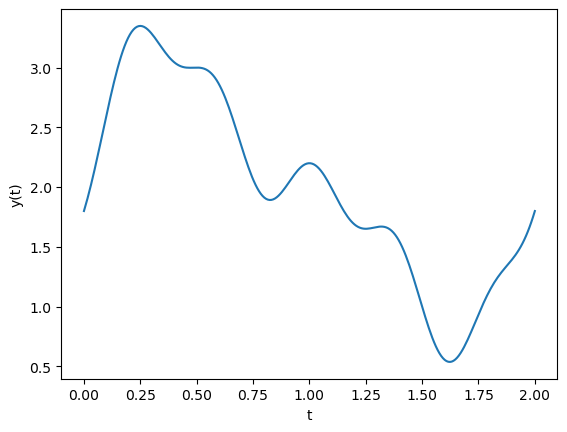

In [2]:
def func(t):
    return 2 + np.sin(t * np.pi) + 0.5*np.sin(2*t*np.pi) - 0.2*np.cos(5*t*np.pi)

num_samples = 32
sample_rate = 8
t = np.linspace(0, 2, num_samples * sample_rate)
y = func(t)
plt.xlabel("t")
plt.ylabel("y(t)")
plt.plot(t, y)

The *Fourier Transform* transfers this function from the time domain, where it is fairly complex, lots of samples to keep track of and so forth, to the frequency domain. Let's take a look at the function in the frequency domain:

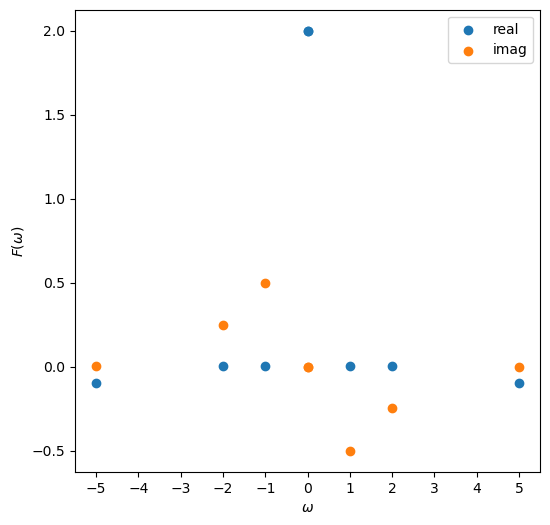

In [3]:
Y = np.fft.fft(y)
num_freqs = 4
order = np.argsort(np.abs(Y[:num_samples // 2]))[::-1]
freqs = np.fft.fftfreq(num_samples * sample_rate)

select = order[:4].tolist() + [-i for i in order[:4]]
plt.figure(figsize=(6, 6))
plt.xticks(np.arange(-5, 6))
plt.xlabel("$\omega$")
plt.ylabel("$F(\omega)$")
plt.scatter(freqs[select] * len(freqs), Y[select].real / len(freqs), label="real")
plt.scatter(freqs[select] * len(freqs), Y[select].imag / len(freqs), label="imag")
plt.legend()

These few samples in the frequency domain define the function, and we can use an *Inverse Fourier Transform* to reconstruct the entire signal from these samples. The interactive plot below lets you see how adding in the different frequency basis functions will reconstruct the signal:

In [ ]:
def _plot_basis1d(basis=0):
    subset = np.zeros_like(Y)
    f = order[basis]
    subset[f] = Y[f]
    subset[-f] = Y[-f]
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(t, np.real(np.fft.ifft(subset)))
    plt.title("Basis @ {}hz".format(len(freqs) * freqs[f]))
    
    for f in order[:basis]:
        subset[f] = Y[f]
        subset[-f] = Y[-f]

    plt.subplot(122)
    plt.plot(t, np.real(np.fft.ifft(subset)))
    plt.plot(t, func(t))
    plt.title("Reconstruction")
    plt.show()

interact(_plot_basis1d, basis=(0, 3))

In [ ]:
## Hyperparameters ##

num_plot = 48
max_hidden = 10
num_steps = 10000
num_layers = 1
num_channels = 64

#####################

dataset = ffn.SignalDataset.create(func, num_samples, sample_rate)
model = ffn.MLP(1, 1, num_layers, num_channels)
model.layers[-1].bias.data = dataset.train_y.mean()
torch.nn.init.xavier_normal_(model.layers[-1].weight, dataset.train_y.std())

def _loss(model, x, target_y):
    output_y = model(x)
    return (output_y - target_y).square().mean()

def _validate(model, dataset):
    model.eval()
    with torch.no_grad():
        loss = _loss(model, dataset.val_x, dataset.val_y)
    
    model.train()
    return loss.item()

LogEntry = namedtuple("LogEntry", ["step", "train_loss", "val_loss", "state"])

def _train(model, dataset, learning_rate):
    optim = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=1e-3)
    log = []
    bar = ffn.ETABar("Training", max=num_steps)
    for step in range(num_steps):
        optim.zero_grad()
        train_loss = _loss(model, dataset.train_x, dataset.train_y)
        train_loss.backward()
        optim.step()

        if step % 200 == 0:
            bar.next(200)
            train_loss = train_loss.item()
            val_loss = _validate(model, dataset)
            state_dict = copy.deepcopy(model.state_dict())
            log.append(LogEntry(step, train_loss, val_loss, state_dict))
            bar.info("train: {:.2e} val: {:.2e}".format(train_loss, val_loss))

    bar.finish()
    return log

def _plot_fourier1d(log, step=0, max_hidden=10):
    fig = plt.figure(figsize=(10, 5))
    colors = plt.get_cmap("viridis")(np.linspace(0, 1, num_plot))[..., :3]
    hidden_ax = fig.add_subplot(121)
    space_ax = fig.add_subplot(122)
    entry = log[step]
    model.load_state_dict(entry.state)
    dataset.plot(space_ax, hidden_ax, model, num_plot, colors, max_hidden)
    plt.show()

The question at hand is whether we can achieve this same task using a Multi-Layer Perceptron, or MLP.  It seems like we should be able to. We can set up the problem easily enough. Our training data is values of $t$ and their corresponding $f(t)$ value using the same function we've been looking at. The loss function will be:

$$
L(\theta,t,f)=\frac{1}{N}\sum_t(f(t) - y(t, \theta))^2
$$

That is, the mean squared error between the true value, $f(t$, and the predicted value, $y(t, \theta)$ where $\theta$ is the model parameters. Another useful measure we'll be using is Peak Signal-to-Noise Ratio, or PSNR, computed as:

$$
PSNR(\theta,t,f)=-10 \log(2L(\theta, t, f))
$$

For a model, we'll use a simple MLP. The cell below will train such an MLP. Try out different hyperparameter values in the cell above and see what happens. In the lecture, we tried `num_channels = [64, 256, 512, 1024]` and `num_layers = [1, 4]`.

In [ ]:
mlp_log = _train(model, dataset, 1e-3)
interact(_plot_fourier1d, step=(0, len(mlp_log) - 1), max_hidden=(5, 15), log=fixed(mlp_log))

Let's interact with the training logs to see how the neural net is trying to solve this problem. On the left you will see the top hidden layers, and on the right you will see the current reconstruction for the selected step in training. 

In the case of `num_layers=1`, you can clearly see that the MLP is trying to reconstruct the signal by separating the input space into sections and then trying to reconstruct the signal by combining those sections together. `num_layers=4` lets the network create more and more complex basis functions (aside from just lines) that it can use to reconstruct the signal, but ultimately the neural net is limited to linear combinations of line segments and will thus struggle with high frequency signals.

However, if you look at the signals coming out of deeper networks, they look quite a lot like combinations of Fourier basis functions. What if we were to incorporate these into the model somehow? We can do this by computing the following values using t:

$$
\gamma(t) = [\ldots, \frac{1}{\omega}\cos(\pi \omega t), \frac{1}{\omega}\sin(\pi \omega t),\ldots], \omega \in [1,N]
$$

If we set $N$ to the Nyquist frequency, then the MLP will essentially be able to learn to combine these basis functions to reconstruct the signal.

![Fourier Feature Network Diagram](docs/fourier_feature_1d_diagram.png)

The result is a *Fourier Feature Network*. Let's try training one and see what happens:

In [ ]:
## Hyperparameters ##

num_channels = 64
num_layers = 1

#####################

b_values = np.arange(1, num_samples // 2 + 1).astype(np.float32)
b_values = torch.from_numpy(b_values).reshape(1, -1)
a_values = 1 / np.arange(1, num_samples // 2 + 1).astype(np.float32)
a_values = torch.from_numpy(a_values)
model = ffn.FourierFeatureMLP(1, 1, a_values, b_values,
                               [num_channels] * num_layers)
model.layers[-1].bias.data = dataset.train_y.mean()
torch.nn.init.xavier_normal_(model.layers[-1].weight, dataset.train_y.std())

pos_log = _train(model, dataset, 5e-4)
interact(_plot_fourier1d, step=(0, len(pos_log) - 1), max_hidden=(5, 15), log=fixed(pos_log))

Note how in almost no time it is able to perfectly reconstruct the input signal. Of course, this is somewhat to be expected, as this is a bit of a contrived scenario. Let's try a different signal:

In [ ]:
def triangle(t):
    section_length = 0.5
    section0 = t < section_length
    section1 = (t >= section_length) & (t < 2 * section_length)
    section2 = (t >= 2 * section_length) & (t < 3 * section_length)
    section3 = t >= 3 * section_length
    output = np.zeros_like(t)
    output[section0] = t[section0]
    output[section1] = 2 * section_length - t[section1]
    output[section2] = t[section2] - 2 * section_length
    output[section3] = 4 * section_length - t[section3]
    return output

## Hyperparameters ##

num_channels = 64
num_layers = 1

#####################

dataset = ffn.SignalDataset.create(triangle, num_samples, sample_rate)
model = ffn.FourierFeatureMLP(1, 1, a_values, b_values,
                               [num_channels] * num_layers)
model.layers[-1].bias.data = dataset.train_y.mean()
torch.nn.init.xavier_normal_(model.layers[-1].weight, dataset.train_y.std())

pos_log = _train(model, dataset, 5e-4)

interact(_plot_fourier1d, step=(0, len(pos_log) - 1), max_hidden=(5, 15), log=fixed(pos_log))

## 2. Modeling Images

Let's move on to the more challenging problem of modeling images. In particular, we want to predict the RGB value of a pixel from its $(u,v)$ normalized image location. Before we get to the machine learning, however, let's revisit signal and data processing again, this time in two dimensions.

Here is a cute image of a cat:

In [ ]:
image = cv2.imread(os.path.join("data", "cat.jpg"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255
plt.imshow(image, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.show()

Using a *2D Fourier Transform*, we can transfer this image from the space (i.e. $uv$) domain, to the frequency domain:

In [ ]:
def _fft2(image):
    image_freq = np.fft.fft2(np.fft.ifftshift(image))
    image_freq = np.fft.fftshift(image_freq)
    return image_freq

def _ifft2(image_freq):
    image = np.fft.ifft2(np.fft.ifftshift(image_freq))
    image = np.fft.fftshift(image)
    return image.real    

image_freq = _fft2(image)
plt.imshow(np.log(np.abs(image_freq)))
plt.xticks([])
plt.yticks([])
plt.show()

Each pixel in the frequency image above corresponds to a different *sinusoidal grating*, that is a image of bars at varying frequency, phase, and rotation. In the animation below, we can see how adding together these gratings via a *Inverse 2D Fourier Transform* allows us to reconstitute the original image.

In [ ]:
image_freq_flat = image_freq.reshape(-1)
order = np.argsort(np.abs(image_freq_flat))[::-1]
i_vals = order // image_freq.shape[1]
j_vals = order % image_freq.shape[1]
max_num_freqs = 20000
num_frames = 60

stops = np.exp(np.linspace(0, np.log(max_num_freqs), num_frames + 1)).astype(np.int32)
stops = np.unique(stops).tolist()
stops.append(max_num_freqs)

def _plot_basis2d(basis=0):
    subset = np.zeros_like(image_freq)
    start = stops[basis]
    end = stops[basis + 1]
    if end == start:
        end = start + 1

    subset[i_vals[start:end], j_vals[start:end]] = image_freq[i_vals[start:end], j_vals[start:end]]
    subset[-i_vals[start:end], -j_vals[start:end]] = image_freq[-i_vals[start:end], -j_vals[start:end]]

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(_ifft2(subset))
    plt.title("Basis {} to {}".format(start, end))
    
    subset[i_vals[:start], j_vals[:start]] = image_freq[i_vals[:start], j_vals[:start]]
    subset[-i_vals[:start], -j_vals[:start]] = image_freq[-i_vals[:start], -j_vals[:start]]

    plt.subplot(122)
    plt.imshow(_ifft2(subset), cmap="gray")
    plt.title("Reconstruction")
    plt.show()

interact(_plot_basis2d, basis=(0, len(stops) - 2))

Can we train a neural net to reconstruct images as well? The problem is as follows: take an image and sample every other pixel (i.e. at quarter resolution). These pixels are the training data. We will evaluate the network on the whole image. For reference, that looks like this:

In [ ]:
image = cv2.imread(os.path.join("data", "cat.jpg"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255

fig = plt.figure(figsize=(8, 4))
train_ax = fig.add_subplot(121)
val_ax = fig.add_subplot(122)

train_image = image[::2, ::2]
train_ax.imshow(image[::2, ::2], interpolation=None)
train_ax.set_title("Training")
train_ax.set_xlim(0, 512)
train_ax.set_ylim(512, 0)
val_ax.imshow(image)
val_ax.set_title("Validation")
fig.tight_layout()
plt.show()

If it has learned a mapping from $uv$ space to RGB, then it should be able to upscale and fill in the missing pixels. Let's see how we do with a standard MLP:

In [ ]:
## Hyperparameters ##

num_steps = 2000
num_layers = 3
num_channels = 64

#####################

## Dataset ##
paths = ["cat.jpg", "garden.jpg", "rubik.jpg", "sea.jpg", "trees.jpg"]
dataset = ffn.PixelDataset.create(paths[0], "RGB")
dataset = dataset.to(device)

############

model = ffn.MLP(2, 3, num_layers, num_channels)
model = model.to(device)

def _loss2d(model, uv, target_color):
    output_color = torch.sigmoid(model(uv))
    return (target_color - output_color).square().mean()

def _validate2d(model, dataset):
    model.eval()
    with torch.no_grad():
        output_color = torch.sigmoid(model(dataset.val_uv))
        psnr = dataset.psnr(output_color)
    
    model.train()
    return psnr

LogEntry2d = namedtuple("LogEntry", ["step", "val_psnr", "state"])

def _train2d(model, dataset, learning_rate):
    optim = torch.optim.Adam(model.parameters(), learning_rate)
    log = []
    bar = ffn.ETABar("Training", max=num_steps)
    for step in range(num_steps):
        optim.zero_grad()
        train_loss = _loss2d(model, dataset.train_uv, dataset.train_color)
        train_loss.backward()
        optim.step()

        if step % 200 == 0:
            bar.next(200)
            val_psnr = _validate2d(model, dataset)
            state_dict = copy.deepcopy(model.state_dict())
            log.append(LogEntry2d(step, val_psnr, state_dict))
            bar.info("psnr: {:.2f}".format(val_psnr))
    
    bar.finish()
    return log

def _plot_image2d(log, step=0):
    fig = plt.figure(figsize=(15, 5))
    hidden_ax = fig.add_subplot(131)
    hidden_ax.set_xticks([])
    hidden_ax.set_yticks([])
    recon_ax = fig.add_subplot(132)
    recon_ax.set_xticks([])
    recon_ax.set_yticks([])
    gt_ax = fig.add_subplot(133)
    gt_ax.set_xticks([])
    gt_ax.set_yticks([])
    entry = log[step]
    model.load_state_dict(entry.state)
    model.eval()

    with torch.no_grad():
        colors = torch.sigmoid(model(dataset.val_uv))
        hidden_ax.imshow(dataset.to_act_image(model, 512))
        recon_ax.imshow(dataset.to_image(colors, 512))

    gt_ax.imshow(dataset.image)
    fig.tight_layout()
    plt.show()

In [ ]:
mlp2_log = _train2d(model, dataset, 1e-3)
interact(_plot_image2d, step=(0, len(mlp2_log) - 1), log=fixed(mlp2_log))

In this visualization, we see the 64 final activations on the left, the reconstruction in the middle, and the target image on the right. Immediately you can see that the MLP is not able to do a good job of this reconstruction, and seemingly for the same reason it struggled in 1D: it can only work with lines. In this case, all it can do is build polygons in the input space and assign them colors, as you can see in the activations. Each neuron is in charge of a different region of the image, and assigns it a color which then contributes to the final (blurry) reconstruction.

Let's try adding in Fourier features again, this time in 2 dimensions:

$$
\gamma(u,v) = [\ldots, \cos(\pi \omega u), \sin(\pi \omega u), \cos(\pi \omega v), \sin(\pi \omega v), \ldots], \omega=2^k, k \in [0, K]
$$

$K$ here is a parameter we'll call the `max_log_scale`. There are a few good values, but the best value is:

$$
K = \log_2\left(\frac{128}{\pi}\right) \approx 5.35
$$

Can you figure out why? Regardless, let's try training one of these 2D Fourier feature networks and see how it does with this harder problem.

In [ ]:
max_log_scale = np.log(128 / np.pi) / np.log(2)

dataset = ffn.PixelDataset.create(paths[0], "RGB")
dataset = dataset.to(device)
model = ffn.PositionalFourierMLP(2, 3, max_log_scale, num_channels=64)
model = model.to(device)

pos2_log = _train2d(model, dataset, 1e-3)
interact(_plot_image2d, step=(0, len(pos2_log) - 1), log=fixed(pos2_log))

As before, it does an excellent job of reconstructing the image. It can be a bit difficult to see, but each of the activations in this case has access to the full cat image. Each one simply paints different colors onto different parts in preparation for the final compositing and reconstruction. What happens if we try to reconstruct an even larger image?

In [ ]:
# NB: this will use the last set of parameters loaded by the slider above

size = 800

uvs = dataset.generate_uvs(size, device)
model.eval()

with torch.no_grad():
    colors = torch.sigmoid(model(uvs))
    image = dataset.to_image(colors, size)

fig = plt.figure(figsize=(8, 8))
plt.xticks([])
plt.yticks([])
plt.imshow(image)
plt.show()

Be sure to try other images, and other values for `max_log_scale`. What happens if you train with a value of 2, or 10? What happens to the super-resolution image?

## 3. Volume Rendering

Before we move on to modeling 3D functions with Fourier Feature Networks, we are going to take a necessary detour to learn more about *volume rendering*. Volume rendering is a technique that allows us to turn volumetric information into 2D images. It builds on concepts you will already be familiar with from your course. To explore it, we will need some 3D data. We provide several datasets for you to learn with. While `SignalDataset` can be given any 1D function, and `PixelDataset` can be given any image, `RayDataset` requires a specific data format. The datasets we provide are:

| Name         |  image size | # train | # val | # test | Description | Sample image |
|--------------|-------------|---------|-------|--------|-------------|--------------|
| `antinous_(size)` | (size)x(size) | 100 | 7 | 13 | Renders of a [sculpture](https://sketchfab.com/3d-models/antinous-12aad55d55e1480da4811c3a4aa42f5f) kindly provided by the Fitzwilliam Museum. Does not include view-dependent effects.| ![Antinous](docs/antinous.jpg)|
| `rubik_(size)` | (size)x(size) | 100 | 7 | 13 | This work is based on "Rubik's Cube" (https://sketchfab.com/3d-models/rubiks-cube-d7d8aa83720246c782bca30dbadebb98) by BeyondDigital (https://sketchfab.com/BeyondDigital) licensed under CC-BY-4.0 (http://creativecommons.org/licenses/by/4.0/). Does not include view-dependent effects. | ![Rubik](docs/rubik.jpg) |
| `lego_(size)` | (size)x(1.5 * size) | 100 | 7 | 13 | Physically based renders of a lego build, provided by the NeRF authors. | ![Lego](docs/lego.jpg) |
| `trex_(size)` | (size)x(size) | 100 | 7 | 13 | This work is based on "The revenge of the traditional toys" (https://sketchfab.com/3d-models/the-revenge-of-the-traditional-toys-d2dd1ee7948343308cd732c665ef1337) by Bastien Genbrugge (https://sketchfab.com/bastienBGR) licensed under CC-BY-4.0 (http://creativecommons.org/licenses/by/4.0/). Rendered with PBR and thus includes multiple view-dependent effects. | ![T-Rex](docs/trex.jpg) |
| `benin_(size)` | (size)x(size) | 74 | 10 | 0 | Free moving, hand-held photographs of a bronze statue of a rooster from Benin, kindly provided by Jesus College, Cambridge. | ![Benin](docs/benin.jpg) |
| `matthew_(size)` | (size)x(size) | 26 | 5 | 0 | Photographs of me, taken by a 31 camera fixed rig. | ![Matthew](docs/matthew.jpg)

These dataset are provided at both 400 and 800 pixel sizes. In this notebook, we will focus on training with the 400 pixel versions. If you want to use your own dataset, you will need to create an NPZ with the following tensors:

| Name         |     Shape    |  dtype  | description |
|--------------|:------------:|:-------:|-------------|
| images       | (C, D, D, 4) |  uint8  | Tensor of camera images with RGBA pixel values. Alpha value indicates a mask around the object (where appropriate).
| intrinsics   |   (C, 3, 3)  | float32 | Tensor of camera intrinsics (i.e. projection) matrices
| extrinsics   |   (C, 4, 4)  | float32 | Tensor of camera extrinsics (i.e. camera to world) matrices
| bounds       |    (4, 4)    | float32 | Rigid transform indicating the bounds of the volume to be rendered. Will be used to transform a unit cube.
| split_counts |      (3)     |  int32  | Number of cameras (in order) for train, val and test data splits.

You may find it helpful to use one of the provided datasets as a guide.

In [ ]:
model = None
dataset = None
torch.cuda.empty_cache()

num_samples = 64
paths = ["antinous_400.npz", "benin_400.npz", "lego_400.npz", "trex_400.npz", "matthew_400.npz", "rubik_400.npz"]
choice = 0
train_dataset = ffn.ImageDataset.load(paths[choice], "train", num_samples, include_alpha=True, stratified=True)
val_dataset = ffn.ImageDataset.load(paths[choice], "val", num_samples, include_alpha=True, stratified=False)


The cell above should have downloaded one of the datasets and sampled rays from its cameras. Let's take a look inside:

In [ ]:
demo_dataset = ffn.ImageDataset.load(paths[choice], "val", 16, include_alpha=True, stratified=False)
demo_dataset.to_scenepic()

You can move the camera around with the mouse button. Press <kbd>R</kbd> to reset the view. If you press <kbd>&#8594;</kbd> or <kbd>&#8592;</kbd> you can move from camera to camera to see what it sees. For the rest of the controls, see the help message below. You can use the menu in the top right to turn things on and off, for example the blue cube that indicates the bounds of the render volume, the images associated with each camera, or the "empty" samples (i.e. those associated with an alpha value of 0).

How do we position these samples within the space like this? The answer comes from a technique called *ray casting*. Let's begin by reviewing some concepts from the course so far.

In [ ]:
display(Video("https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3YvcyFBbld2SzJiNTFuR3FsdkYydkhOSmtTcjJBdWk5eXc_ZT02MEZUSHM/root/content", width=600, height=300))

### 3.1 Ray Casting

If you press the `play` button above you will see an animation of the math of the world to camera matrix. Recall this equation:
    
$$
\begin{pmatrix}
u \\
v \\
w \\
\end{pmatrix} = C
\begin{pmatrix}
X \\
Y \\
Z \\
1 \\
\end{pmatrix}
$$

This is the camera projection equation, where the camera matrix $C$ projects 3D points in the world into the camera's coordinate space and then projects them onto the image plane.  Recall that we can break $C$ down into two parts:

$$
C=\begin{pmatrix}
f & 0 & c_u \\
0 & f & c_v \\
0 & 0 & 1 \\
\end{pmatrix}
\begin{pmatrix}
\mathbf{R} & \mathbf{t} \\
\mathbf{0} & 1 \\
\end{pmatrix}
$$

The matrix on the left is the *projection* matrix, made of the focal length $f$ and the principal point $(c_u, c_v)$. The matrix on the right is the *world-to-camera* matrix, which rotates the world by the rotation matrix $\mathbf{R}$ and then translates it by $\mathbf{t}$. This process is demonstrated in the animation on the left, with the projection of points from space to camera is depicted by rays shooting from the object to the camera center, through the image plane. Feel free to pause the animation and inspect it to learn more.

When we cast rays into a scene, we use the inverse of this process as seen in the animation on the right. Instead of moving the world into the camera's frame, we move the camera into the world's frame, as you can see on the right. Similarly, instead of projecting points from the world into the camera, we project them out from the camera into the world. The origin $\mathbf{o}$ of these rays is found by multiplying the inverse of the *world-to-camera* matrix (the aptly named *camera-to-world* matrix) with the origin:

$$
\mathbf{o} = \begin{pmatrix}
\mathbf{R} & \mathbf{t} \\
\mathbf{0} & 1 \\
\end{pmatrix}^{-1}\begin{pmatrix}
\mathbf{0} \\
1
\end{pmatrix}
$$

Each ray's direction $\mathbf{d}$ is determined by *unprojecting* the pixel location to obtain a point in 3D space and then subtracting the origin from this point:

$$
\mathbf{d} = C^{-1}\begin{pmatrix}
u \\
v \\
w \\
\end{pmatrix} - \mathbf{o}
$$

We can now find any 3D point on the ray using a single scalar value:

$$
\mathbf{r}(t) = \mathbf{o} + t\mathbf{d}
$$

## 3.2 Radiance Fields

What can we do with these rays? Let's look at a concept of a radiance field. There are a couple different formulations, but let's start with this one:

$$
f: \mathbb{R}^3 \to \mathbb{R}^4 \\
\begin{pmatrix}
red \\
green \\
blue
\end{pmatrix} = \mathbf{c}
\begin{pmatrix}
X \\
Y \\
Z
\end{pmatrix} \\
opacity = \sigma
\begin{pmatrix}
X \\
Y \\
Z
\end{pmatrix}
$$

In this scenario, we have a mapping from $XYZ$ space to color + opacity. Combined with the rays we just created, we can write an equation which relates the color of a pixel in an image to the radiance field:

$$
C(\mathbf{r})=\int_{t_n}^{t_f}T(t)\sigma\left(\mathbf{r}(t)\right)\mathbf{c}\left(\mathbf{r}(t)\right)dt \\
T(t)=\exp\left(-\int_{t_n}^{t_f}\sigma\left(\mathbf{r}(s)\right)ds\right)
$$

There is a lot here, so let's break it down:

1. $t_n$ and $t_f$ are the near and far planes (think of the how the rays are bound by the render cube in the visualization above).
2. $T(t)$ - This function measures how much solid stuff is in front of the current position $t$
3. $\sigma\left(\mathbf{r}(t)\right)$ - This is how opaque the current position is
4. $\mathbf{c}\left(\mathbf{r}(t)\right)$ - This is what the current position looks like

In practice, we're going to want to use a discrete approximation of this integral:

$$
\hat{C}(\mathbf{r}) = \sum_{i=1}^N T_i \left(1 - \exp(-\sigma_i \delta_i)\right)c_i \\
T_i=\exp\left(-\sum_{j=1}^{i-1} o_j \delta_j\right) \\
\delta_i = t_{i+1} - t_i
$$

where each $i$ value corresponds to a discrete $t_i$ sample. Here is a graph of what that looks like:

Break this down a LOT more:

1. Show how $t_n$ and $t_f$ are computed (i.e. voxel intersection)
2. Graph showing $T(t)$. Get a patch and show the pixel and the ray's path through the model with a scenepic, and then show the graph below. Color the samples. 
3. 



In [ ]:
t = []
opacity = []
T = []

with open(os.path.join("docs", "ray_data.tsv")) as file:
    reader = csv.DictReader(file, delimiter="\t")
    for row in reader:
        t.append(float(row["t"]))
        opacity.append(float(row["opacity"]))
        T.append(float(row["T"]))

fig, ax1 = plt.subplots()

ax1.set_xlim(4, 4.6)
ax1.set_xlabel("t")
ax1.set_ylabel("opacity")
ax1.plot(t, opacity)

ax2 = ax1.twinx()
ax2.set_ylabel("T")
ax2.plot(t, T, label="T", color="orange")

plt.show()

The two peaks in the blue line (the $\sigma$ value) indicate that this ray passes through two objects. However, we can see that the orange line (which tracks the $T$ value) starts at 1 as it passes through empty space, but then decreases to 0 as we reach the middle of the first peak. As a result, the colors from the second object will not contribute much of anything to the final pixel color. If the first peak were lower (indicating that the object was less opaque) then $T$ would decrease more slowly, allowing color from the object behind to contribute more.

Let's look at this process a different way.

In [ ]:
display(Video("https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3YvcyFBbld2SzJiNTFuR3FsdUo2RUVaTmpibU5KTFl0WXc_ZT02N2M1Wjk/root/content", width=640, height=360))

### 3.3 Voxels

What is incredibly exciting about this formulation is that it provides a way for us to train a radiance field from images using back propagation and gradient descent. While ultimately we will want to use this to train a neural net, we will begin with a representation that is far simpler: a volumetric pixel, or voxel.

![Minecraft](docs/minecraft.jpg)

You almost certainly have encountered voxels before. They split up a 3D space into small little cubes which play the same role in three dimensions as pixels do in two: taking a large, continuous space and breaking it up into manageable discrete chunks. As we subdivide the space into smaller and smaller chunks, we can represent objects with greater and greater fidelity. Take a look at the animation below:

In [ ]:
display(Video("https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3YvcyFBbld2SzJiNTFuR3FsdkYzWnFGYUtNX2hqWngwWmc_ZT00eHhUeGM/root/content", width=400, height=400))

In [ ]:
## Hyperparameters ##

num_steps = 10000
num_samples = 64
batch_size = 1024
learning_rate = 1e-2
decay_rate = 0.1
decay_steps = 25000
weight_decay = 0.0
num_layers = 3
image_interval = 0
report_interval = 1000
num_channels = 64
crop_steps = 0

###################

model = ffn.Voxels(128, 1)
model = model.to(device)

raycaster = ffn.Raycaster(model)

def _render_log(log, resolution=ffn.Resolution(200, 200), fov=40, distance=4):
    cameras = ffn.orbit(np.array([0, 1, 0], np.float32),
                         np.array([0, 0, -1], np.float32),
                         len(log), fov, resolution, distance)
    sampler = ffn.RaySampler(sp.Transforms.scale(2), cameras, num_samples)
    act_cameras = ffn.orbit(np.array([0, 1, 0], np.float32),
                             np.array([0, 0, -1], np.float32),
                             len(log), fov, ffn.Resolution(64, 64), distance)
    act_sampler = ffn.RaySampler(sp.Transforms.scale(2), act_cameras, num_samples)
    renders = []
    bar = ffn.ETABar("Rendering", max=len(log))
    for i, entry in enumerate(log):
        bar.next()
        raycaster.model.load_state_dict(entry.state)
        image = raycaster.render_image(sampler, i, batch_size)
        act = raycaster.render_activations(act_sampler, i, batch_size)
        renders.append((act, image))

    bar.finish()
    return renders

def _render_orbit(num_frames=20, resolution=ffn.Resolution(200, 200), fov=40, distance=3,
                  opacity_model=None):
    cameras = ffn.orbit(np.array([0, 1, 0], np.float32),
                         np.array([0, 0, -1], np.float32),
                         num_frames, fov, resolution, distance)
    sampler = ffn.RaySampler(sp.Transforms.scale(2), cameras, num_samples, opacity_model=opacity_model)
    renders = []
    bar = ffn.ETABar("Rendering", max=num_frames)
    for i in range(num_frames):
        bar.next()
        image = raycaster.render_image(sampler, i, batch_size)
        renders.append(image)

    bar.finish()
    return renders

def _plot_image3d(renders, frame=0):
    if len(renders[frame]) == 2:
        act, image = renders[frame]    
        fig = plt.figure(figsize=(10, 5))
        hidden_ax = fig.add_subplot(121)
        hidden_ax.set_xticks([])
        hidden_ax.set_yticks([])
        recon_ax = fig.add_subplot(122)
        recon_ax.set_xticks([])
        recon_ax.set_yticks([])
        hidden_ax.imshow(act)
        recon_ax.imshow(image)
        fig.tight_layout()
    else:
        image = renders[frame]
        fig = plt.figure(figsize=(10, 10))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(renders[frame])
        
    plt.show()

To represent a radiance field using voxels, we simply store a value for color and opacity at each voxel location, and then use *tri-linear interpolation* to arrive at the value for each sample. Let's try training a voxel radiance field by running the cells below:

In [ ]:
raycaster.fit(train_dataset, val_dataset, batch_size, learning_rate, num_steps,
              crop_steps, report_interval, decay_rate, decay_steps, weight_decay, [], disable_aml=True)

voxel_renders = _render_orbit()

In [ ]:
interact(_plot_image3d, frame=(0, len(voxel_renders) - 1), renders=fixed(voxel_renders))

As you can see this does a fairly decent job of capturing the shape and appearance of this statue despite only training for 10,000 steps. If you train one of the other dataset you can see the same artifacts we discussed in the lecture, which arise due to the fact that this radiance field maps $XYZ$ to color and opacity, but does not incorporate the view direction. This, however, would no longer be an $OcTree$ but a 6-space tree, which exposes a major problem with using voxels for storage.

A N-space binary tree is an extrapolation of the binary tree to different dimensionalities. The lower ones have names, i.e. QuadTree = 2 dimensions = 4 children, OcTree = 3 dimensions = 8 children, however the concept can apply to any dimensional space. Furthermore, we can count the number of nodes in such a tree for a given depth:

$$
Nodes(D,N) = \sum_{d=1}^{D}2^{Nd-1}
$$

This means that as we move to higher dimensional spaces and try to attain the depth needed to create a high-fidelity repesentation, the space requirement grows exponentially at an exponential rate. As most locations in higher-dimensional spaces are empty, we can save a lot of space by creating a sparse version of the tree, in which we simply don't store empty space, but even still the remaining nodes will grow exponentially in this way. We need another method of modeling radiance fields.

## 4. Neural Volume Rendering

As you have likely guessed, we are going to use neural nets to model radiance fields. Let's see what happens when we try to train an MLP to represent a radiance field using the same training framework we put in place for training the voxel representation:

In [ ]:
model = None
dataset = None
if device == "cuda":
    torch.cuda.empty_cache()

num_samples = 64
paths = ["antinous_400.npz", "benin_400.npz", "lego_400.npz", "trex_400.npz", "matthew_400.npz", "rubik_400.npz"]
choice = 0
train_dataset = ffn.ImageDataset.load(paths[choice], "train", num_samples, include_alpha=True, stratified=True)
val_dataset = ffn.ImageDataset.load(paths[choice], "val", num_samples, include_alpha=True, stratified=False)

In [ ]:
learning_rate = 5e-4
model = ffn.MLP(3, 4, num_channels=64)
raycaster.model = model.to(device)

log = raycaster.fit(train_dataset, val_dataset, batch_size, learning_rate, num_steps,
                    crop_steps, report_interval, decay_rate, decay_steps, weight_decay, [], disable_aml=True)

mlp_renders = _render_log(log)

In [ ]:
interact(_plot_image3d, frame=(0, len(mlp_renders) - 1), renders=fixed(mlp_renders))

The visualization above is a 3D analogue of the 2D visualization we saw earlier, where we have the activations the final 64 hidden neurons on the left, and the reconstruction on the right. As has been the case in 1D and 2D, the MLP has no recourse but to carve up the input space into polyhedrons and assign them colors in order to create the blurry representation we see on the right. Clearly we need to introduce Fourier Features again. As you've likely noticed, these models take a bit longer to train. That is due to there being significantly more data involved. For the 1D signal case, we had 32 training samples. For the 2D case, we had 256 * 256 = 65536 total training points. In the case of the Antinous 400 dataset, for example, we have 100 400x400 images, resulting in 16,000,000 rays. Each of these rays is then sampled `num_samples` times, so let's say we use a value of 64, that means we will run the MLP 1,024,000,000 times before it will have seen the entire dataset. In the immortal words of the poet:

> Space is big. You just won't believe how vastly, hugely, mind-bogglingly big it is.
> I mean, you may think it's a long way down the road to the chemist's, but that's
> just peanuts to space - Douglas Adams

What happens when we train one of these models is that we run a bunch of rays through the ray caster in batches of 1024. Each of these batches is a step. Once the model is trained, we have to visualize the results, which requires rendering images from the volume. For this, we create a camera orbit which circles the model so we can see what it looks like from all sides.

In [ ]:
max_log_scale = 5.5

model = ffn.PositionalFourierMLP(3, 4, max_log_scale, num_channels=64)
raycaster.model = model.to(device)
log = raycaster.fit(train_dataset, val_dataset, batch_size, learning_rate, num_steps,
                    crop_steps, report_interval, decay_rate, decay_steps, weight_decay, [], disable_aml=True)

pos_renders = _render_log(log)

In [ ]:
interact(_plot_image3d, frame=(0, len(pos_renders) - 1), renders=fixed(pos_renders))

The final layer, as in the previous two cases, has access to the full shape of the model, and all that happens in this layer is coloring and fine-tuning. Even after only 10,000 steps (not even once through the dataset) the model is looking rather good, and worlds better than the MLP. You'll notice that `max_log_scale` has made a reappearance. It is less clear what the best value should be for this case, though empirically 5.5-6 is a good range. You should definitely see what happens when you try different values. 

Now that we have a working neural model for a radiance field, let's set about improving it. The first and obvious step is to give the model more capacity. As we were just discussing we have no shortage of data, so we can safely grow the model without too much worry about overfitting. Next, we should take another look at sampling. You may have noticed that I created the `train_dataset` variable with the setting `stratified=True`. The standard means of sampling rays for volume sampling is a series of equally spaced samples along the ray (as is the case with the visualization we looked at earlier). With stratified sampling, we perturb the regular samples slightly so that the expected distance between samples remains the same but the samples themselves move around the space more:

$$
t_i ~ U\left[t_n + \frac{i - 1}{N}(t_f - t_n), t_n + \frac{i}{N}(t_f - t_n)\right]
$$

What this means is that we sample each $t_i$ from a uniform random distribution centered on the regularly space sample $t_n$ and scaled by the length of the ray $t_f - t_n$. We can see what that looks like below:

In [ ]:
train_dataset.sample_cameras(7, 32, stratified=True).to_scenepic()

You can see how the samples are still even spread over the space, but also randomly distributed. This means that during training, the model will eventually see samples from every part of the render volume, enabling it to learn fine details. The second sampling trick we will use is to incorporate opacity information from a pretrained model. Let's look at the discrete approximation of the volume rendering integral again:

$$
\hat{C}(\mathbf{r})=\sum_{i=1}^Nw_ic_i \\
w_i = T_i(1 - \exp(-\sigma_i\delta_i))
$$

These $w_i$ values, when normalized, can be treated as a probability distribution over the ray of where we are likely to find "solid stuff". If we incorporate sampling from this distribution into the stratified sampling, then we can speed up training and get better details on models by spending more time sampling in useful places and not empty spaces. Let's see what that looks like:

In [ ]:
opacity_model = ffn.load_model("antinous_800_vox128.pt")
focus_dataset = ffn.ImageDataset.load("antinous_400.npz", "val", num_samples, include_alpha=True,
                                     stratified=True, opacity_model=opacity_model)
focus_dataset.to_scenepic()

Last but certainly not least, we will add in the view direction, creating what is the most common formulation of a radiance field: $f: \mathbb{R}^6 \to \mathbb{R}^4$, in which the position and the view direction both contribute to the resulting color and opacity. This final structure looks like this:

![NeRF Model](docs/nerf_diagram.png)

A few important notes here:

1. The extra layers cause signal degradation and gradient attenuation so we add in a skip connection that directly connects the inputs to the 5th layer.
2. The view direction is encoded separately and added in quite late in the process via a linear merging layer.
3. While the position and view direction are used jointly to predict color, it is NOT used to predict opacity. That is predicted just from position, to encourage multiview consistency.

This is a very powerful model, capable of producing really beautiful renders, but it can also take a LONG time to train. There are a second set of datasets (the 800 resolution ones) which are built for use with this model. Training takes upwards of 24 hours for 200k steps. I recommend you run it in the cloud using the script provided. However, I have made some pretrained models available for you to play with. See below:

In [ ]:
model_paths = ["antinous_800_nerf.pt", "lego_800_nerf.pt", "trex_800_nerf.pt", "benin_800_nerf.pt", "matthew_800_nerf.pt"]
model_path = model_paths[0]
opacity_model_path = model_path.replace("_nerf", "_vox128")
model = ffn.load_model(model_path)
raycaster.model = model.to(device)

opacity_model = ffn.load_model(opacity_model_path)
opacity_model = opacity_model.to(device)

nerf_renders = _render_orbit(resolution=ffn.Resolution(400, 400), opacity_model=opacity_model)

In [ ]:
interact(_plot_image3d, frame=(0, len(nerf_renders) - 1), renders=fixed(nerf_renders))

I hope you found these interactive notes to be an helpful addition to the lecture. The content here is heavily endebted to two papers:

1. Tancik, M. et al. _Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains_. NeurIPS 2020. [Project page](https://bmild.github.io/fourfeat/)
2. Mildenhall, B. et al. _NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis_. ECCV 2020. [Project page](https://www.matthewtancik.com/nerf).

You may also want to read:

Garbin, S. et al. _FastNeRF: High-Fidelity Neural Rendering at 200FPS_. ICCV 2021. [Project page](https://microsoft.github.io/FastNeRF/)

To learn how to take these techniques and make them super fast. 

Finally, if you liked the cool 3D animations, check out [ScenePic](https://microsoft.github.io/scenepic/). Thank you!